This notebook contains cells to train GAN (Cramer GAN modification) to learn data distribution. Unlike in standard training pipelines, the train/test sets are two disjoint sets.

**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [8]:
!pip install tensorflow-addons

In [9]:
import datetime
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from experiments.efficiency.uncertainty_model_train import train_model
from experiments.efficiency.uncertainty_models import uncertainty_mlp
from experiments.efficiency.uncertainty_utils import \
    efficiency_momentum_with_uncertainty
from experiments.efficiency.utils import (efficiency_momentum,
                                          ensemble_and_ref_model_inference,
                                          tf_to_numpy_dataset,
                                          threshold_selection)
from src.dataset import CramerGANDataset
from src.cramer_gan_trainer import CramerGANTrainer
from src.datasets.utils_rich import (get_merged_typed_dataset,
                                     parse_dataset_np, parse_example)

from src.models.gans.discriminators.fcn_disc import RICHDiscriminator
from src.models.gans.generators.fcn_gen import RichMCDropFunc

### Data preparation

The RICH dataset contains sets of data for different types of particles. Each datapoint in RICH consists of $\mathbb{X}, \mathbb{Y}$ and weight $w$, where the input data $\mathbb{X} \in \mathbb{R}^3$, where features of input data consist of pseudorapidity (ETA), momentum (P), number of tracks; the output is data $\mathbb{Y} \in \mathbb{R}^5$, where each feature is the difference of log-likelihood values between particle hypothesis and pion hypothesis. The particles are kaon, proton, muon, electron, and values below the threshold.

In [10]:
particle_type = 'pion'

data_dir = 'rich'

In [11]:
ls rich

kaon2_-_down_2016_.csv  muon_-_down_2016_.csv   pion_-_down_2016_.csv
kaon2_+_down_2016_.csv  muon_+_down_2016_.csv   pion_+_down_2016_.csv
kaon2_-_up_2016_.csv    muon_-_up_2016_.csv     pion_-_up_2016_.csv
kaon2_+_up_2016_.csv    muon_+_up_2016_.csv     pion_+_up_2016_.csv
kaon_-_down_2016_.csv   pion2_-_down_2016_.csv  proton_-_down_2016_.csv
kaon_+_down_2016_.csv   pion2_+_down_2016_.csv  proton_+_down_2016_.csv
kaon_-_up_2016_.csv     pion2_-_up_2016_.csv    proton_-_up_2016_.csv
kaon_+_up_2016_.csv     pion2_+_up_2016_.csv    proton_+_up_2016_.csv


In this notebook we make train/test split as two disjoint sets. Taking the symmetry of the data after standardization, we split the data by the line $y = x$ (we consider pseudorapidity (ETA) and momentum (P) for split).

In [12]:
def _split_by_line(df, slope=1, intercept=0):
    top_half = df[df['Brunel_ETA'] > df['Brunel_P'] * slope + intercept]
    bottom_half = df[df['Brunel_ETA'] <= df['Brunel_P'] * slope + intercept]

    top_half = top_half.reset_index(drop=True)
    bottom_half = bottom_half.reset_index(drop=True)

    return top_half, bottom_half


def split_by_line(df_train, df_test):
    return _split_by_line(df_train)[0], _split_by_line(df_test)[1]


def split_by_line_btstrap(df_train, df_test, sample_size=int(0.75e6)):
    train, val = split_by_line(df_train, df_test)
    train = train.sample(sample_size, replace=False)

    return train, val

In [13]:
data_train, data_val, scaler = get_merged_typed_dataset(data_dir, particle_type,
                                                        dtype=np.float32, log=True, 
                                                        sample_fn=split_by_line)

Reading and concatenating datasets:
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.025728940963745
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


In [14]:
data_train.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0 -1.254825 -0.040824  -1.886267  ...   -0.669189       -0.548956       0.965707
1  0.931232  1.038058   0.607882  ...    1.356350       -0.475871       0.665584
2  1.378112  0.909597   1.173054  ...    1.936912       -1.036041       1.081870
3  0.004241  0.059028   1.323287  ...    0.504079        0.201282       1.078090
4 -1.532684  0.465442  -1.539660  ...   -0.789812       -0.131059       1.078320

[5 rows x 9 columns]

In [15]:
data_val.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0  0.410903 -2.077369   0.448014  ...   -2.181621        0.474075       0.957473
1 -0.653586 -1.325109  -0.581912  ...   -0.918851        0.748689       0.825602
2  0.295756  0.260714  -0.013731  ...    0.593576        1.160335       1.234150
3 -0.138550 -0.861487  -0.136917  ...    0.115588        0.201282       0.288768
4 -0.617368  1.368743   1.323357  ...   -1.715811        1.169351       0.907071

[5 rows x 9 columns]

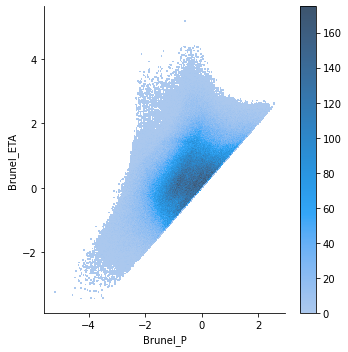

In [16]:
sns.displot(data_train, x='Brunel_P', y='Brunel_ETA', cbar=True)

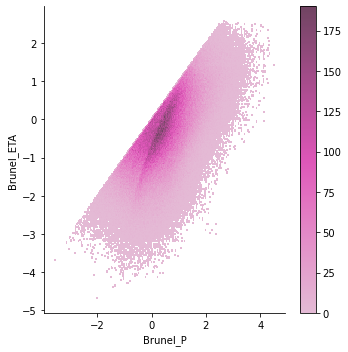

In [17]:
sns.displot(data_val, x='Brunel_P', y='Brunel_ETA', cbar=True, color='tab:pink')

In [18]:
data_train.shape

(947947, 9)

In [19]:
data_val.shape

(524521, 9)

### Model definition

The generator is six-layer mlp with dropout after each layer except last. Each hidden layer contains 128 units. The dropout rate is usually in the range of 0.1 - 0.2 (calibration results). This rate is enough to train a "diverse" ensemble keeping the performance on benchmark at a considerable level. The discriminator is six-layer mlp. 


In [34]:
gen_config = {
    'drop_rate': 0.01,
    'dropout_type': 'bernoulli_structured',
    'drop_kwargs': {'patch_size': 3}
}

generator = RichMCDropFunc(**gen_config)
generator.summary(line_length=96)

Model: "virtual_ensemble_model_5"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0              
                                                                                             

In [22]:
generator.losses

[]

In [27]:
discriminator = RICHDiscriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 8)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 256)          100224      ['concatenate[0][0]']        

We use Cramer GAN modification to train generator learn the distribution. [Link](https://arxiv.org/abs/1705.10743) to Cramer GAN for more details. The training configuration:
 - Batch size: 1000
 - Critic steps: 15
 - Generator optimizer: RMSProp with learning rate 0.0002
 - Discriminator optimizer: RMSProp with learning rate 0.0002
 - Use weights: True
 - Number of epochs: 400

In [40]:
critic_batch_size = 15
batch_size = int(1e3)

num_val = data_val.shape[0]
num_train = data_train.shape[0]

train_dataset_config = {
    'data_np': data_train,
    'iter_batch_size': critic_batch_size + 1,
    'batch_size': batch_size
}

val_dataset_config = {
    'data_np': data_val,
    'num_instances': 1,
    'iter_batch_size': 1,
    'batch_size': num_val,
    'shuffle': False
}

dataset_train = CramerGANDataset(**train_dataset_config)
dataset_val = CramerGANDataset(**val_dataset_config)

print("Train dataset shape: ", tf.data.experimental.cardinality(dataset_train.dataset))
print("Val dataset shape: ", tf.data.experimental.cardinality(dataset_val.dataset))

Train dataset shape:  tf.Tensor(59, shape=(), dtype=int64)
Val dataset shape:  tf.Tensor(1, shape=(), dtype=int64)


In [41]:
checkpoint_base = 'checkpoints'
exp_name = 'bernoulli_structured_dropout_line_test_cramer_weighted'
checkpoint_dir = os.path.join(checkpoint_base, exp_name)

logs_base = 'logs'
log_dir = os.path.join(logs_base, exp_name)

generator_optimizer = tf.keras.optimizers.RMSprop(2e-4) 
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4)

trainer_config = {
    'generator': generator,
    'discriminator': discriminator,
    'generator_optimizer': generator_optimizer,
    'discriminator_optimizer': discriminator_optimizer,
    'checkpoint_dir': checkpoint_dir,
    'log_dir': log_dir,
    'reg_loss_lambda': 0.
}

trainer = CramerGANTrainer(**trainer_config)

0.0


In [43]:
trainer.fit_cramer(400, dataset_train, dataset_val, weighted=True)

  7%|▋         | 64000/944000 [00:26<04:55, 2976.74it/s, gen_loss=0.637, disc_loss=-.608, reg_loss=0]

  8%|▊         | 80000/944000 [00:30<04:22, 3289.98it/s, gen_loss=0.756, disc_loss=-.637, reg_loss=0]

100%|██████████| 944000/944000 [04:22<00:00, 3602.71it/s, gen_loss=0.336, disc_loss=-.352, reg_loss=0]


Time taken for epoch 1 is 262.02850556373596 sec



100%|██████████| 944000/944000 [01:07<00:00, 14014.36it/s, gen_loss=0.44, disc_loss=-.25, reg_loss=0]


Time taken for epoch 2 is 67.36579918861389 sec



100%|██████████| 944000/944000 [01:06<00:00, 14135.39it/s, gen_loss=0.236, disc_loss=-.228, reg_loss=0]


Time taken for epoch 3 is 66.78809642791748 sec



100%|██████████| 944000/944000 [01:07<00:00, 14066.96it/s, gen_loss=0.207, disc_loss=-.337, reg_loss=0]


Time taken for epoch 4 is 67.11601758003235 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.01it/s, gen_loss=0.134, disc_loss=-.155, reg_loss=0]


Time taken for epoch 5 is 81.99371385574341 sec



100%|██████████| 944000/944000 [01:06<00:00, 14286.86it/s, gen_loss=0.567, disc_loss=-.128, reg_loss=0]


Time taken for epoch 6 is 66.08198833465576 sec



100%|██████████| 944000/944000 [01:06<00:00, 14286.04it/s, gen_loss=0.127, disc_loss=0.0266, reg_loss=0]


Time taken for epoch 7 is 66.08369970321655 sec



100%|██████████| 944000/944000 [01:06<00:00, 14251.12it/s, gen_loss=0.119, disc_loss=-.0317, reg_loss=0]


Time taken for epoch 8 is 66.24749302864075 sec



100%|██████████| 944000/944000 [01:05<00:00, 14304.44it/s, gen_loss=-.355, disc_loss=-.334, reg_loss=0]


Time taken for epoch 9 is 66.002361536026 sec



100%|██████████| 944000/944000 [01:06<00:00, 14253.23it/s, gen_loss=0.129, disc_loss=0.0242, reg_loss=0]


Time taken for epoch 10 is 66.23674941062927 sec



100%|██████████| 944000/944000 [01:06<00:00, 14097.13it/s, gen_loss=0.0426, disc_loss=-.468, reg_loss=0]


Time taken for epoch 11 is 66.97083568572998 sec



100%|██████████| 944000/944000 [01:06<00:00, 14267.42it/s, gen_loss=0.422, disc_loss=-.295, reg_loss=0]


Time taken for epoch 12 is 66.17086052894592 sec



100%|██████████| 944000/944000 [01:06<00:00, 14162.96it/s, gen_loss=0.188, disc_loss=0.0743, reg_loss=0]


Time taken for epoch 13 is 66.65826296806335 sec



100%|██████████| 944000/944000 [01:06<00:00, 14276.75it/s, gen_loss=-.193, disc_loss=-.294, reg_loss=0]


Time taken for epoch 14 is 66.12867212295532 sec



100%|██████████| 944000/944000 [01:06<00:00, 14211.56it/s, gen_loss=0.34, disc_loss=-.0463, reg_loss=0]


Time taken for epoch 15 is 66.42969965934753 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.33it/s, gen_loss=-.0107, disc_loss=-.285, reg_loss=0]


Time taken for epoch 16 is 81.99321007728577 sec



100%|██████████| 944000/944000 [01:06<00:00, 14192.48it/s, gen_loss=0.276, disc_loss=-.11, reg_loss=0]


Time taken for epoch 17 is 66.51895236968994 sec



100%|██████████| 944000/944000 [01:06<00:00, 14194.02it/s, gen_loss=0.0267, disc_loss=0.178, reg_loss=0]


Time taken for epoch 18 is 66.51677107810974 sec



100%|██████████| 944000/944000 [01:06<00:00, 14104.43it/s, gen_loss=-.0342, disc_loss=0.0918, reg_loss=0]


Time taken for epoch 19 is 66.93530178070068 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.75it/s, gen_loss=0.11, disc_loss=-.383, reg_loss=0]


Time taken for epoch 20 is 82.09926652908325 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.28it/s, gen_loss=0.328, disc_loss=0.152, reg_loss=0]


Time taken for epoch 21 is 81.99096727371216 sec



100%|██████████| 944000/944000 [01:06<00:00, 14146.85it/s, gen_loss=0.101, disc_loss=0.0129, reg_loss=0]


Time taken for epoch 22 is 66.73424530029297 sec



100%|██████████| 944000/944000 [01:06<00:00, 14246.73it/s, gen_loss=0.172, disc_loss=-.142, reg_loss=0]


Time taken for epoch 23 is 66.27180051803589 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.21it/s, gen_loss=-.0294, disc_loss=-.306, reg_loss=0]


Time taken for epoch 24 is 81.99122428894043 sec



100%|██████████| 944000/944000 [01:07<00:00, 14068.14it/s, gen_loss=0.0429, disc_loss=0.0269, reg_loss=0]


Time taken for epoch 25 is 67.10737347602844 sec



100%|██████████| 944000/944000 [01:06<00:00, 14096.47it/s, gen_loss=0.389, disc_loss=0.0229, reg_loss=0]


Time taken for epoch 26 is 66.97373080253601 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.77it/s, gen_loss=-.0358, disc_loss=0.218, reg_loss=0]


Time taken for epoch 27 is 81.99482536315918 sec



100%|██████████| 944000/944000 [01:07<00:00, 14028.51it/s, gen_loss=-.0422, disc_loss=0.0486, reg_loss=0]


Time taken for epoch 28 is 67.29834914207458 sec



100%|██████████| 944000/944000 [01:06<00:00, 14166.22it/s, gen_loss=0.236, disc_loss=-.0342, reg_loss=0]


Time taken for epoch 29 is 66.6423830986023 sec



100%|██████████| 944000/944000 [01:06<00:00, 14231.95it/s, gen_loss=0.0147, disc_loss=-.201, reg_loss=0]


Time taken for epoch 30 is 66.33903503417969 sec



100%|██████████| 944000/944000 [01:06<00:00, 14151.15it/s, gen_loss=0.00192, disc_loss=-.0112, reg_loss=0]


Time taken for epoch 31 is 66.71705079078674 sec



100%|██████████| 944000/944000 [01:06<00:00, 14183.38it/s, gen_loss=0.369, disc_loss=-.131, reg_loss=0]


Time taken for epoch 32 is 66.56273436546326 sec



100%|██████████| 944000/944000 [01:06<00:00, 14109.61it/s, gen_loss=0.189, disc_loss=-.308, reg_loss=0]


Time taken for epoch 33 is 66.91090774536133 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.23it/s, gen_loss=-.199, disc_loss=-.11, reg_loss=0]


Time taken for epoch 34 is 81.99196934700012 sec



100%|██████████| 944000/944000 [01:06<00:00, 14137.84it/s, gen_loss=-.144, disc_loss=0.0889, reg_loss=0]


Time taken for epoch 35 is 66.77739214897156 sec



100%|██████████| 944000/944000 [01:06<00:00, 14213.84it/s, gen_loss=0.334, disc_loss=0.0608, reg_loss=0]


Time taken for epoch 36 is 66.42009830474854 sec



100%|██████████| 944000/944000 [01:06<00:00, 14257.86it/s, gen_loss=0.561, disc_loss=-.349, reg_loss=0]


Time taken for epoch 37 is 66.21496200561523 sec



100%|██████████| 944000/944000 [01:06<00:00, 14193.79it/s, gen_loss=0.37, disc_loss=0.178, reg_loss=0]


Time taken for epoch 38 is 66.5156078338623 sec



100%|██████████| 944000/944000 [01:07<00:00, 14058.80it/s, gen_loss=-.027, disc_loss=-.233, reg_loss=0]


Time taken for epoch 39 is 67.15448570251465 sec



100%|██████████| 944000/944000 [01:06<00:00, 14198.78it/s, gen_loss=-.117, disc_loss=0.0741, reg_loss=0]


Time taken for epoch 40 is 67.33905053138733 sec



100%|██████████| 944000/944000 [01:07<00:00, 14023.30it/s, gen_loss=0.226, disc_loss=-.283, reg_loss=0]


Time taken for epoch 41 is 67.32029581069946 sec



100%|██████████| 944000/944000 [01:07<00:00, 14058.94it/s, gen_loss=0.338, disc_loss=-.29, reg_loss=0]


Time taken for epoch 42 is 67.15588593482971 sec



100%|██████████| 944000/944000 [01:06<00:00, 14249.32it/s, gen_loss=0.247, disc_loss=-.321, reg_loss=0]


Time taken for epoch 43 is 66.25415062904358 sec



100%|██████████| 944000/944000 [01:05<00:00, 14305.61it/s, gen_loss=0.317, disc_loss=-.108, reg_loss=0]


Time taken for epoch 44 is 65.99495935440063 sec



100%|██████████| 944000/944000 [01:07<00:00, 14075.20it/s, gen_loss=-.0758, disc_loss=0.0129, reg_loss=0]


Time taken for epoch 45 is 67.07398247718811 sec



100%|██████████| 944000/944000 [01:06<00:00, 14232.48it/s, gen_loss=0.0526, disc_loss=0.024, reg_loss=0]


Time taken for epoch 46 is 66.33386063575745 sec



100%|██████████| 944000/944000 [01:06<00:00, 14210.86it/s, gen_loss=-.085, disc_loss=-.0962, reg_loss=0]


Time taken for epoch 47 is 66.43431901931763 sec



100%|██████████| 944000/944000 [01:06<00:00, 14097.40it/s, gen_loss=0.0686, disc_loss=0.114, reg_loss=0]


Time taken for epoch 48 is 66.9703516960144 sec



100%|██████████| 944000/944000 [01:06<00:00, 14147.64it/s, gen_loss=0.097, disc_loss=-.217, reg_loss=0]


Time taken for epoch 49 is 66.73069190979004 sec



100%|██████████| 944000/944000 [01:06<00:00, 14130.70it/s, gen_loss=0.199, disc_loss=0.0104, reg_loss=0]


Time taken for epoch 50 is 66.81232404708862 sec



100%|██████████| 944000/944000 [01:06<00:00, 14193.79it/s, gen_loss=0.117, disc_loss=-.182, reg_loss=0]


Time taken for epoch 51 is 66.51299023628235 sec



100%|██████████| 944000/944000 [01:06<00:00, 14192.93it/s, gen_loss=-.129, disc_loss=0.228, reg_loss=0]


Time taken for epoch 52 is 66.51929903030396 sec



100%|██████████| 944000/944000 [01:06<00:00, 14271.52it/s, gen_loss=0.0278, disc_loss=0.11, reg_loss=0]


Time taken for epoch 53 is 66.15189051628113 sec



100%|██████████| 944000/944000 [01:06<00:00, 14150.40it/s, gen_loss=0.129, disc_loss=-.319, reg_loss=0]


Time taken for epoch 54 is 66.72000336647034 sec



100%|██████████| 944000/944000 [01:06<00:00, 14189.62it/s, gen_loss=0.0889, disc_loss=-.273, reg_loss=0]


Time taken for epoch 55 is 66.53424310684204 sec



100%|██████████| 944000/944000 [01:06<00:00, 14298.40it/s, gen_loss=0.352, disc_loss=-.0687, reg_loss=0]


Time taken for epoch 56 is 66.03073573112488 sec



100%|██████████| 944000/944000 [01:06<00:00, 14150.95it/s, gen_loss=0.0323, disc_loss=-.293, reg_loss=0]


Time taken for epoch 57 is 66.71695756912231 sec



100%|██████████| 944000/944000 [01:06<00:00, 14199.81it/s, gen_loss=0.0249, disc_loss=-.0596, reg_loss=0]


Time taken for epoch 58 is 66.48629355430603 sec



100%|██████████| 944000/944000 [01:06<00:00, 14162.85it/s, gen_loss=0.136, disc_loss=0.029, reg_loss=0]


Time taken for epoch 59 is 66.66068053245544 sec



100%|██████████| 944000/944000 [01:07<00:00, 14056.64it/s, gen_loss=0.194, disc_loss=-.0543, reg_loss=0]


Time taken for epoch 60 is 67.28450727462769 sec



100%|██████████| 944000/944000 [01:06<00:00, 14196.72it/s, gen_loss=0.036, disc_loss=-.0164, reg_loss=0]


Time taken for epoch 61 is 66.49946451187134 sec



100%|██████████| 944000/944000 [01:06<00:00, 14172.39it/s, gen_loss=-.0796, disc_loss=-.329, reg_loss=0]


Time taken for epoch 62 is 66.61672735214233 sec



100%|██████████| 944000/944000 [01:07<00:00, 14080.77it/s, gen_loss=-.0652, disc_loss=-.0064, reg_loss=0]


Time taken for epoch 63 is 67.04918122291565 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.55it/s, gen_loss=-.0796, disc_loss=-.24, reg_loss=0]


Time taken for epoch 64 is 81.99876642227173 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.90it/s, gen_loss=-.0533, disc_loss=-.079, reg_loss=0]


Time taken for epoch 65 is 81.99364447593689 sec



100%|██████████| 944000/944000 [01:06<00:00, 14182.61it/s, gen_loss=0.123, disc_loss=-.136, reg_loss=0]


Time taken for epoch 66 is 66.57045102119446 sec



100%|██████████| 944000/944000 [01:06<00:00, 14091.94it/s, gen_loss=0.113, disc_loss=-.0188, reg_loss=0]


Time taken for epoch 67 is 66.99568176269531 sec



100%|██████████| 944000/944000 [01:07<00:00, 14087.64it/s, gen_loss=0.1, disc_loss=-.176, reg_loss=0]


Time taken for epoch 68 is 67.01538276672363 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.04it/s, gen_loss=0.116, disc_loss=-.0764, reg_loss=0]


Time taken for epoch 69 is 81.99311113357544 sec



100%|██████████| 944000/944000 [01:06<00:00, 14249.88it/s, gen_loss=0.00554, disc_loss=-.207, reg_loss=0]


Time taken for epoch 70 is 66.252756357193 sec



100%|██████████| 944000/944000 [01:07<00:00, 14063.74it/s, gen_loss=0.115, disc_loss=-.0176, reg_loss=0]


Time taken for epoch 71 is 67.12901997566223 sec



100%|██████████| 944000/944000 [01:07<00:00, 14051.39it/s, gen_loss=0.0657, disc_loss=-.226, reg_loss=0]


Time taken for epoch 72 is 67.18685293197632 sec



100%|██████████| 944000/944000 [01:07<00:00, 13995.02it/s, gen_loss=0.107, disc_loss=0.138, reg_loss=0]


Time taken for epoch 73 is 67.45979452133179 sec



100%|██████████| 944000/944000 [01:06<00:00, 14185.46it/s, gen_loss=0.112, disc_loss=-.0921, reg_loss=0]


Time taken for epoch 74 is 66.55545043945312 sec



100%|██████████| 944000/944000 [01:06<00:00, 14221.58it/s, gen_loss=0.0307, disc_loss=-.0633, reg_loss=0]


Time taken for epoch 75 is 66.38497185707092 sec



100%|██████████| 944000/944000 [01:07<00:00, 14065.13it/s, gen_loss=0.0679, disc_loss=0.0936, reg_loss=0]


Time taken for epoch 76 is 67.1211085319519 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.60it/s, gen_loss=0.275, disc_loss=-.173, reg_loss=0]


Time taken for epoch 77 is 81.9955735206604 sec



100%|██████████| 944000/944000 [01:07<00:00, 14067.49it/s, gen_loss=0.32, disc_loss=-.0724, reg_loss=0]


Time taken for epoch 78 is 67.11045241355896 sec



100%|██████████| 944000/944000 [01:06<00:00, 14190.87it/s, gen_loss=0.0172, disc_loss=-.0612, reg_loss=0]


Time taken for epoch 79 is 66.52924084663391 sec



100%|██████████| 944000/944000 [01:06<00:00, 14134.50it/s, gen_loss=-.0288, disc_loss=-.212, reg_loss=0]


Time taken for epoch 80 is 66.87916612625122 sec



100%|██████████| 944000/944000 [01:06<00:00, 14095.30it/s, gen_loss=0.0688, disc_loss=0.0124, reg_loss=0]


Time taken for epoch 81 is 66.97744011878967 sec



100%|██████████| 944000/944000 [01:07<00:00, 14082.20it/s, gen_loss=0.093, disc_loss=-.249, reg_loss=0]


Time taken for epoch 82 is 67.04111957550049 sec



100%|██████████| 944000/944000 [01:07<00:00, 13962.88it/s, gen_loss=0.0184, disc_loss=-.0217, reg_loss=0]


Time taken for epoch 83 is 67.6141664981842 sec



100%|██████████| 944000/944000 [01:06<00:00, 14156.71it/s, gen_loss=0.19, disc_loss=-.157, reg_loss=0]


Time taken for epoch 84 is 66.68851327896118 sec



100%|██████████| 944000/944000 [01:06<00:00, 14172.10it/s, gen_loss=0.107, disc_loss=0.114, reg_loss=0]


Time taken for epoch 85 is 66.61539340019226 sec



100%|██████████| 944000/944000 [01:07<00:00, 14048.88it/s, gen_loss=-.111, disc_loss=-.00758, reg_loss=0]


Time taken for epoch 86 is 67.20125007629395 sec



100%|██████████| 944000/944000 [01:06<00:00, 14113.78it/s, gen_loss=0.0191, disc_loss=-.0786, reg_loss=0]


Time taken for epoch 87 is 66.89034962654114 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.35it/s, gen_loss=-.267, disc_loss=0.0586, reg_loss=0]


Time taken for epoch 88 is 82.00020813941956 sec



100%|██████████| 944000/944000 [01:07<00:00, 14042.22it/s, gen_loss=0.207, disc_loss=-.016, reg_loss=0]


Time taken for epoch 89 is 67.23306274414062 sec



100%|██████████| 944000/944000 [01:06<00:00, 14114.53it/s, gen_loss=0.136, disc_loss=-.0183, reg_loss=0]


Time taken for epoch 90 is 66.88888335227966 sec



100%|██████████| 944000/944000 [01:07<00:00, 13963.41it/s, gen_loss=-.116, disc_loss=0.0983, reg_loss=0]


Time taken for epoch 91 is 67.61058831214905 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.29it/s, gen_loss=0.323, disc_loss=-.0139, reg_loss=0]


Time taken for epoch 92 is 81.99449610710144 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.84it/s, gen_loss=-.109, disc_loss=0.00248, reg_loss=0]


Time taken for epoch 93 is 81.99538779258728 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.78it/s, gen_loss=-.0258, disc_loss=-.136, reg_loss=0]


Time taken for epoch 94 is 81.9945740699768 sec



100%|██████████| 944000/944000 [01:07<00:00, 13950.83it/s, gen_loss=0.182, disc_loss=-.0648, reg_loss=0]


Time taken for epoch 95 is 67.67588639259338 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.64it/s, gen_loss=0.0821, disc_loss=0.134, reg_loss=0]


Time taken for epoch 96 is 81.99577713012695 sec



100%|██████████| 944000/944000 [01:06<00:00, 14093.47it/s, gen_loss=0.0607, disc_loss=-.0814, reg_loss=0]


Time taken for epoch 97 is 66.98906588554382 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.44it/s, gen_loss=0.00227, disc_loss=-.0571, reg_loss=0]


Time taken for epoch 98 is 81.99361324310303 sec



100%|██████████| 944000/944000 [01:07<00:00, 13979.96it/s, gen_loss=0.0932, disc_loss=-.0884, reg_loss=0]


Time taken for epoch 99 is 67.53115558624268 sec



100%|██████████| 944000/944000 [01:07<00:00, 13972.61it/s, gen_loss=0.236, disc_loss=-.102, reg_loss=0]


Time taken for epoch 100 is 67.66158604621887 sec



100%|██████████| 944000/944000 [01:07<00:00, 14023.54it/s, gen_loss=0.211, disc_loss=0.061, reg_loss=0]


Time taken for epoch 101 is 67.32010245323181 sec



100%|██████████| 944000/944000 [01:07<00:00, 14051.19it/s, gen_loss=0.252, disc_loss=0.154, reg_loss=0]


Time taken for epoch 102 is 67.18839430809021 sec



100%|██████████| 944000/944000 [01:06<00:00, 14100.35it/s, gen_loss=0.287, disc_loss=-.106, reg_loss=0]


Time taken for epoch 103 is 66.95686864852905 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.02it/s, gen_loss=0.0359, disc_loss=-.0128, reg_loss=0]


Time taken for epoch 104 is 81.99357891082764 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.66it/s, gen_loss=-.242, disc_loss=-.0508, reg_loss=0]


Time taken for epoch 105 is 81.99553799629211 sec



100%|██████████| 944000/944000 [01:07<00:00, 14069.66it/s, gen_loss=0.0774, disc_loss=0.231, reg_loss=0]


Time taken for epoch 106 is 67.10044813156128 sec



100%|██████████| 944000/944000 [01:07<00:00, 14061.16it/s, gen_loss=-.0768, disc_loss=0.298, reg_loss=0]


Time taken for epoch 107 is 67.14070630073547 sec



100%|██████████| 944000/944000 [01:06<00:00, 14095.72it/s, gen_loss=0.183, disc_loss=-.0509, reg_loss=0]


Time taken for epoch 108 is 66.97685194015503 sec



100%|██████████| 944000/944000 [01:06<00:00, 14156.18it/s, gen_loss=0.0815, disc_loss=0.0432, reg_loss=0]


Time taken for epoch 109 is 66.693199634552 sec



100%|██████████| 944000/944000 [01:07<00:00, 14060.46it/s, gen_loss=0.036, disc_loss=-.218, reg_loss=0]


Time taken for epoch 110 is 67.14362335205078 sec



100%|██████████| 944000/944000 [01:06<00:00, 14195.82it/s, gen_loss=-.00679, disc_loss=-.0723, reg_loss=0]


Time taken for epoch 111 is 66.50439691543579 sec



100%|██████████| 944000/944000 [01:06<00:00, 14096.08it/s, gen_loss=-.0266, disc_loss=-.121, reg_loss=0]


Time taken for epoch 112 is 66.97764778137207 sec



100%|██████████| 944000/944000 [01:06<00:00, 14224.06it/s, gen_loss=0.182, disc_loss=-.178, reg_loss=0]


Time taken for epoch 113 is 66.37418174743652 sec



100%|██████████| 944000/944000 [01:06<00:00, 14107.97it/s, gen_loss=0.158, disc_loss=-.206, reg_loss=0]


Time taken for epoch 114 is 66.91821098327637 sec



100%|██████████| 944000/944000 [01:06<00:00, 14096.14it/s, gen_loss=0.467, disc_loss=-.195, reg_loss=0]


Time taken for epoch 115 is 66.97588467597961 sec



100%|██████████| 944000/944000 [01:06<00:00, 14093.34it/s, gen_loss=-.149, disc_loss=0.0891, reg_loss=0]


Time taken for epoch 116 is 66.991534948349 sec



100%|██████████| 944000/944000 [01:06<00:00, 14125.55it/s, gen_loss=-.206, disc_loss=0.119, reg_loss=0]


Time taken for epoch 117 is 66.83506798744202 sec



100%|██████████| 944000/944000 [01:06<00:00, 14118.31it/s, gen_loss=-.0998, disc_loss=-.315, reg_loss=0]


Time taken for epoch 118 is 66.8700339794159 sec



100%|██████████| 944000/944000 [01:06<00:00, 14102.67it/s, gen_loss=0.0584, disc_loss=-.188, reg_loss=0]


Time taken for epoch 119 is 66.94349360466003 sec



100%|██████████| 944000/944000 [01:06<00:00, 14136.12it/s, gen_loss=-.0105, disc_loss=-.226, reg_loss=0]


Time taken for epoch 120 is 66.87647342681885 sec



100%|██████████| 944000/944000 [01:07<00:00, 13957.16it/s, gen_loss=-.049, disc_loss=-.176, reg_loss=0]


Time taken for epoch 121 is 67.64063501358032 sec



100%|██████████| 944000/944000 [01:07<00:00, 14043.27it/s, gen_loss=0.246, disc_loss=-.225, reg_loss=0]


Time taken for epoch 122 is 67.22759079933167 sec



100%|██████████| 944000/944000 [01:07<00:00, 14032.94it/s, gen_loss=-.242, disc_loss=0.106, reg_loss=0]


Time taken for epoch 123 is 67.28236484527588 sec



100%|██████████| 944000/944000 [01:06<00:00, 14110.17it/s, gen_loss=0.208, disc_loss=0.000554, reg_loss=0]


Time taken for epoch 124 is 66.90759611129761 sec



100%|██████████| 944000/944000 [01:06<00:00, 14135.24it/s, gen_loss=-.0204, disc_loss=0.013, reg_loss=0]


Time taken for epoch 125 is 66.79277658462524 sec



100%|██████████| 944000/944000 [01:07<00:00, 14055.87it/s, gen_loss=-.311, disc_loss=-.0932, reg_loss=0]


Time taken for epoch 126 is 67.16848874092102 sec



100%|██████████| 944000/944000 [01:06<00:00, 14111.56it/s, gen_loss=0.369, disc_loss=0.0811, reg_loss=0]


Time taken for epoch 127 is 66.90176677703857 sec



100%|██████████| 944000/944000 [01:06<00:00, 14100.44it/s, gen_loss=0.0315, disc_loss=-.171, reg_loss=0]


Time taken for epoch 128 is 66.95701599121094 sec



100%|██████████| 944000/944000 [01:06<00:00, 14183.90it/s, gen_loss=-.0736, disc_loss=-.0946, reg_loss=0]


Time taken for epoch 129 is 66.56388568878174 sec



100%|██████████| 944000/944000 [01:07<00:00, 14047.32it/s, gen_loss=0.145, disc_loss=0.0246, reg_loss=0]


Time taken for epoch 130 is 67.20694065093994 sec



100%|██████████| 944000/944000 [01:07<00:00, 13967.49it/s, gen_loss=0.272, disc_loss=0.0082, reg_loss=0]


Time taken for epoch 131 is 67.59207510948181 sec



100%|██████████| 944000/944000 [01:07<00:00, 14078.68it/s, gen_loss=0.0261, disc_loss=0.117, reg_loss=0]


Time taken for epoch 132 is 67.05939841270447 sec



100%|██████████| 944000/944000 [01:06<00:00, 14158.16it/s, gen_loss=0.238, disc_loss=-.115, reg_loss=0]


Time taken for epoch 133 is 66.68103790283203 sec



100%|██████████| 944000/944000 [01:07<00:00, 14083.69it/s, gen_loss=0.22, disc_loss=0.15, reg_loss=0]


Time taken for epoch 134 is 67.03596115112305 sec



100%|██████████| 944000/944000 [01:07<00:00, 14036.87it/s, gen_loss=0.112, disc_loss=0.0555, reg_loss=0]


Time taken for epoch 135 is 67.26324820518494 sec



100%|██████████| 944000/944000 [01:07<00:00, 14057.69it/s, gen_loss=0.0841, disc_loss=-.266, reg_loss=0]


Time taken for epoch 136 is 67.15777325630188 sec



100%|██████████| 944000/944000 [01:07<00:00, 14058.25it/s, gen_loss=0.251, disc_loss=-.0969, reg_loss=0]


Time taken for epoch 137 is 67.15560245513916 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.44it/s, gen_loss=-.0282, disc_loss=0.0299, reg_loss=0]


Time taken for epoch 138 is 81.9991443157196 sec



100%|██████████| 944000/944000 [01:06<00:00, 14227.97it/s, gen_loss=-.122, disc_loss=0.0158, reg_loss=0]


Time taken for epoch 139 is 66.36318802833557 sec



100%|██████████| 944000/944000 [01:06<00:00, 14209.36it/s, gen_loss=-.253, disc_loss=0.0796, reg_loss=0]


Time taken for epoch 140 is 66.5538375377655 sec



100%|██████████| 944000/944000 [01:05<00:00, 14375.71it/s, gen_loss=-.0144, disc_loss=-.1, reg_loss=0]


Time taken for epoch 141 is 65.6723062992096 sec



100%|██████████| 944000/944000 [01:05<00:00, 14341.16it/s, gen_loss=0.0372, disc_loss=0.0769, reg_loss=0]


Time taken for epoch 142 is 65.83151865005493 sec



100%|██████████| 944000/944000 [01:05<00:00, 14381.46it/s, gen_loss=-.0818, disc_loss=0.0232, reg_loss=0]


Time taken for epoch 143 is 65.64668011665344 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.59it/s, gen_loss=0.0611, disc_loss=-.0802, reg_loss=0]


Time taken for epoch 144 is 81.99657845497131 sec



100%|██████████| 944000/944000 [01:05<00:00, 14357.22it/s, gen_loss=-.0921, disc_loss=-.133, reg_loss=0]


Time taken for epoch 145 is 65.75786304473877 sec



100%|██████████| 944000/944000 [01:06<00:00, 14242.39it/s, gen_loss=0.0645, disc_loss=-.0915, reg_loss=0]


Time taken for epoch 146 is 66.28675174713135 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.79it/s, gen_loss=0.0663, disc_loss=0.0961, reg_loss=0]


Time taken for epoch 147 is 81.99362921714783 sec



100%|██████████| 944000/944000 [01:06<00:00, 14191.01it/s, gen_loss=0.113, disc_loss=-.034, reg_loss=0]


Time taken for epoch 148 is 66.52719473838806 sec



100%|██████████| 944000/944000 [01:06<00:00, 14292.15it/s, gen_loss=0.101, disc_loss=-.112, reg_loss=0]


Time taken for epoch 149 is 66.06162095069885 sec



100%|██████████| 944000/944000 [01:06<00:00, 14140.72it/s, gen_loss=0.24, disc_loss=-.0943, reg_loss=0]


Time taken for epoch 150 is 66.76252150535583 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.66it/s, gen_loss=0.0193, disc_loss=0.0214, reg_loss=0]


Time taken for epoch 151 is 82.0003719329834 sec



100%|██████████| 944000/944000 [01:06<00:00, 14107.86it/s, gen_loss=-.188, disc_loss=-.123, reg_loss=0]


Time taken for epoch 152 is 66.91782999038696 sec



100%|██████████| 944000/944000 [01:05<00:00, 14314.32it/s, gen_loss=0.0814, disc_loss=-.000958, reg_loss=0]


Time taken for epoch 153 is 65.95661973953247 sec



100%|██████████| 944000/944000 [01:06<00:00, 14191.70it/s, gen_loss=-.00286, disc_loss=-.15, reg_loss=0]


Time taken for epoch 154 is 66.52821493148804 sec



100%|██████████| 944000/944000 [01:06<00:00, 14236.33it/s, gen_loss=-.00704, disc_loss=0.0259, reg_loss=0]


Time taken for epoch 155 is 66.31474828720093 sec



100%|██████████| 944000/944000 [01:06<00:00, 14170.18it/s, gen_loss=-.0276, disc_loss=0.0756, reg_loss=0]


Time taken for epoch 156 is 66.62867140769958 sec



100%|██████████| 944000/944000 [01:06<00:00, 14242.93it/s, gen_loss=0.164, disc_loss=-.00822, reg_loss=0]


Time taken for epoch 157 is 66.28787851333618 sec



100%|██████████| 944000/944000 [01:06<00:00, 14113.42it/s, gen_loss=0.219, disc_loss=0.0159, reg_loss=0]


Time taken for epoch 158 is 66.89254021644592 sec



100%|██████████| 944000/944000 [01:05<00:00, 14369.91it/s, gen_loss=-.0603, disc_loss=-.0794, reg_loss=0]


Time taken for epoch 159 is 65.70309591293335 sec



100%|██████████| 944000/944000 [01:06<00:00, 14279.93it/s, gen_loss=-.0642, disc_loss=-.26, reg_loss=0]


Time taken for epoch 160 is 66.22320294380188 sec



100%|██████████| 944000/944000 [01:06<00:00, 14242.19it/s, gen_loss=0.0762, disc_loss=-.0111, reg_loss=0]


Time taken for epoch 161 is 66.28666162490845 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.55it/s, gen_loss=0.0988, disc_loss=-.07, reg_loss=0]


Time taken for epoch 162 is 81.99894189834595 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.74it/s, gen_loss=0.12, disc_loss=-.00775, reg_loss=0]


Time taken for epoch 163 is 81.99971795082092 sec



100%|██████████| 944000/944000 [01:06<00:00, 14114.04it/s, gen_loss=-.0452, disc_loss=-.0318, reg_loss=0]


Time taken for epoch 164 is 66.88883185386658 sec



100%|██████████| 944000/944000 [01:06<00:00, 14230.67it/s, gen_loss=0.137, disc_loss=0.0252, reg_loss=0]


Time taken for epoch 165 is 66.34168672561646 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.59it/s, gen_loss=0.208, disc_loss=-.0991, reg_loss=0]


Time taken for epoch 166 is 81.99696445465088 sec



100%|██████████| 944000/944000 [01:06<00:00, 14155.35it/s, gen_loss=-.00363, disc_loss=-.225, reg_loss=0]


Time taken for epoch 167 is 66.6945333480835 sec



100%|██████████| 944000/944000 [01:06<00:00, 14108.26it/s, gen_loss=0.163, disc_loss=-.212, reg_loss=0]


Time taken for epoch 168 is 66.92251420021057 sec



100%|██████████| 944000/944000 [01:06<00:00, 14228.58it/s, gen_loss=0.202, disc_loss=-.106, reg_loss=0]


Time taken for epoch 169 is 66.35351920127869 sec



100%|██████████| 944000/944000 [01:05<00:00, 14360.71it/s, gen_loss=-.0408, disc_loss=-.0925, reg_loss=0]


Time taken for epoch 170 is 65.74158573150635 sec



100%|██████████| 944000/944000 [01:06<00:00, 14158.50it/s, gen_loss=0.0863, disc_loss=-.0585, reg_loss=0]


Time taken for epoch 171 is 66.6866204738617 sec



100%|██████████| 944000/944000 [01:05<00:00, 14350.11it/s, gen_loss=0.0674, disc_loss=-.047, reg_loss=0]


Time taken for epoch 172 is 65.78828191757202 sec



100%|██████████| 944000/944000 [01:06<00:00, 14159.06it/s, gen_loss=0.0589, disc_loss=-.0119, reg_loss=0]


Time taken for epoch 173 is 66.6774160861969 sec



100%|██████████| 944000/944000 [01:06<00:00, 14158.16it/s, gen_loss=-.083, disc_loss=-.08, reg_loss=0]


Time taken for epoch 174 is 66.68100762367249 sec



100%|██████████| 944000/944000 [01:06<00:00, 14252.75it/s, gen_loss=0.0191, disc_loss=0.0946, reg_loss=0]


Time taken for epoch 175 is 66.24096012115479 sec



100%|██████████| 944000/944000 [01:07<00:00, 14073.22it/s, gen_loss=0.0744, disc_loss=-.0572, reg_loss=0]


Time taken for epoch 176 is 67.08232426643372 sec



100%|██████████| 944000/944000 [01:06<00:00, 14196.30it/s, gen_loss=0.16, disc_loss=0.00873, reg_loss=0]


Time taken for epoch 177 is 66.50191497802734 sec



100%|██████████| 944000/944000 [01:07<00:00, 14076.01it/s, gen_loss=0.0574, disc_loss=-.0463, reg_loss=0]


Time taken for epoch 178 is 67.07027339935303 sec



100%|██████████| 944000/944000 [01:07<00:00, 14015.16it/s, gen_loss=0.0128, disc_loss=-.142, reg_loss=0]


Time taken for epoch 179 is 67.36839437484741 sec



100%|██████████| 944000/944000 [01:07<00:00, 14067.46it/s, gen_loss=-.0608, disc_loss=-.00594, reg_loss=0]


Time taken for epoch 180 is 67.203932762146 sec



100%|██████████| 944000/944000 [01:06<00:00, 14133.01it/s, gen_loss=-.126, disc_loss=0.0544, reg_loss=0]


Time taken for epoch 181 is 66.79891633987427 sec



100%|██████████| 944000/944000 [01:06<00:00, 14193.48it/s, gen_loss=-.0494, disc_loss=0.0733, reg_loss=0]


Time taken for epoch 182 is 66.51511192321777 sec



100%|██████████| 944000/944000 [01:06<00:00, 14173.16it/s, gen_loss=0.037, disc_loss=0.0193, reg_loss=0]


Time taken for epoch 183 is 66.61138677597046 sec



100%|██████████| 944000/944000 [01:07<00:00, 14038.36it/s, gen_loss=0.0955, disc_loss=0.00332, reg_loss=0]


Time taken for epoch 184 is 67.25296950340271 sec



100%|██████████| 944000/944000 [01:06<00:00, 14146.45it/s, gen_loss=0.0726, disc_loss=-.159, reg_loss=0]


Time taken for epoch 185 is 66.7356104850769 sec



100%|██████████| 944000/944000 [01:06<00:00, 14159.08it/s, gen_loss=-4.96e-5, disc_loss=-.185, reg_loss=0]


Time taken for epoch 186 is 66.67747735977173 sec



100%|██████████| 944000/944000 [01:07<00:00, 14044.85it/s, gen_loss=-.158, disc_loss=0.197, reg_loss=0]


Time taken for epoch 187 is 67.21952414512634 sec



100%|██████████| 944000/944000 [01:06<00:00, 14113.32it/s, gen_loss=0.193, disc_loss=-.0363, reg_loss=0]


Time taken for epoch 188 is 66.89557790756226 sec



100%|██████████| 944000/944000 [01:06<00:00, 14183.48it/s, gen_loss=0.155, disc_loss=-.0633, reg_loss=0]


Time taken for epoch 189 is 66.56243562698364 sec



100%|██████████| 944000/944000 [01:06<00:00, 14149.79it/s, gen_loss=0.0186, disc_loss=-.00396, reg_loss=0]


Time taken for epoch 190 is 66.72442197799683 sec



100%|██████████| 944000/944000 [01:07<00:00, 14078.49it/s, gen_loss=0.0752, disc_loss=-.207, reg_loss=0]


Time taken for epoch 191 is 67.06119012832642 sec



100%|██████████| 944000/944000 [01:06<00:00, 14218.24it/s, gen_loss=0.0236, disc_loss=0.0386, reg_loss=0]


Time taken for epoch 192 is 66.40079259872437 sec



100%|██████████| 944000/944000 [01:06<00:00, 14111.53it/s, gen_loss=-.428, disc_loss=0.0384, reg_loss=0]


Time taken for epoch 193 is 66.90427327156067 sec



100%|██████████| 944000/944000 [01:07<00:00, 14000.31it/s, gen_loss=0.172, disc_loss=-.0731, reg_loss=0]


Time taken for epoch 194 is 67.43251013755798 sec



100%|██████████| 944000/944000 [01:06<00:00, 14210.20it/s, gen_loss=-.00794, disc_loss=-.0675, reg_loss=0]


Time taken for epoch 195 is 66.43819642066956 sec



100%|██████████| 944000/944000 [01:06<00:00, 14196.07it/s, gen_loss=0.0644, disc_loss=-.124, reg_loss=0]


Time taken for epoch 196 is 66.50546026229858 sec



100%|██████████| 944000/944000 [01:06<00:00, 14183.40it/s, gen_loss=0.069, disc_loss=0.0425, reg_loss=0]


Time taken for epoch 197 is 66.56351685523987 sec



100%|██████████| 944000/944000 [01:06<00:00, 14142.92it/s, gen_loss=-.05, disc_loss=0.0128, reg_loss=0]


Time taken for epoch 198 is 66.75570750236511 sec



100%|██████████| 944000/944000 [01:06<00:00, 14134.11it/s, gen_loss=-.0897, disc_loss=-.0501, reg_loss=0]


Time taken for epoch 199 is 66.79897880554199 sec



100%|██████████| 944000/944000 [01:06<00:00, 14252.86it/s, gen_loss=-.044, disc_loss=0.0517, reg_loss=0]


Time taken for epoch 200 is 66.33077096939087 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.96it/s, gen_loss=-.0531, disc_loss=0.0501, reg_loss=0]


Time taken for epoch 201 is 81.9925901889801 sec



100%|██████████| 944000/944000 [01:06<00:00, 14162.50it/s, gen_loss=0.195, disc_loss=0.0235, reg_loss=0]


Time taken for epoch 202 is 66.65974140167236 sec



100%|██████████| 944000/944000 [01:06<00:00, 14102.93it/s, gen_loss=0.00984, disc_loss=-.295, reg_loss=0]


Time taken for epoch 203 is 66.94236588478088 sec



100%|██████████| 944000/944000 [01:06<00:00, 14187.44it/s, gen_loss=-.028, disc_loss=0.0386, reg_loss=0]


Time taken for epoch 204 is 66.55233955383301 sec



100%|██████████| 944000/944000 [01:06<00:00, 14297.42it/s, gen_loss=-.0483, disc_loss=0.0349, reg_loss=0]


Time taken for epoch 205 is 66.03262758255005 sec



100%|██████████| 944000/944000 [01:06<00:00, 14165.95it/s, gen_loss=-.0578, disc_loss=0.0715, reg_loss=0]


Time taken for epoch 206 is 66.64438533782959 sec



100%|██████████| 944000/944000 [01:06<00:00, 14261.21it/s, gen_loss=-.000469, disc_loss=-.227, reg_loss=0]


Time taken for epoch 207 is 66.20180606842041 sec



100%|██████████| 944000/944000 [01:07<00:00, 14036.97it/s, gen_loss=0.0368, disc_loss=0.0439, reg_loss=0]


Time taken for epoch 208 is 67.25769186019897 sec



100%|██████████| 944000/944000 [01:06<00:00, 14276.60it/s, gen_loss=0.0865, disc_loss=-.0328, reg_loss=0]


Time taken for epoch 209 is 66.13199043273926 sec



100%|██████████| 944000/944000 [01:06<00:00, 14269.38it/s, gen_loss=-.0362, disc_loss=-.0628, reg_loss=0]


Time taken for epoch 210 is 66.16175413131714 sec



100%|██████████| 944000/944000 [01:06<00:00, 14111.20it/s, gen_loss=-.107, disc_loss=-.0506, reg_loss=0]


Time taken for epoch 211 is 66.90758872032166 sec



100%|██████████| 944000/944000 [01:06<00:00, 14126.05it/s, gen_loss=0.257, disc_loss=-.051, reg_loss=0]


Time taken for epoch 212 is 66.83558678627014 sec



100%|██████████| 944000/944000 [01:07<00:00, 14059.55it/s, gen_loss=-.037, disc_loss=-.206, reg_loss=0]


Time taken for epoch 213 is 67.15065264701843 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.24it/s, gen_loss=0.0389, disc_loss=-.119, reg_loss=0]


Time taken for epoch 214 is 82.00027203559875 sec



100%|██████████| 944000/944000 [01:06<00:00, 14197.04it/s, gen_loss=-.165, disc_loss=0.0128, reg_loss=0]


Time taken for epoch 215 is 66.49975824356079 sec



100%|██████████| 944000/944000 [01:07<00:00, 14026.62it/s, gen_loss=-.00866, disc_loss=-.0858, reg_loss=0]


Time taken for epoch 216 is 67.31015300750732 sec



100%|██████████| 944000/944000 [01:06<00:00, 14195.63it/s, gen_loss=0.15, disc_loss=-.0919, reg_loss=0]


Time taken for epoch 217 is 66.50790190696716 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.94it/s, gen_loss=0.209, disc_loss=0.314, reg_loss=0]


Time taken for epoch 218 is 81.99990153312683 sec



100%|██████████| 944000/944000 [01:06<00:00, 14218.64it/s, gen_loss=0.015, disc_loss=0.0989, reg_loss=0]


Time taken for epoch 219 is 66.40063405036926 sec



100%|██████████| 944000/944000 [01:07<00:00, 14024.96it/s, gen_loss=0.0853, disc_loss=-.144, reg_loss=0]


Time taken for epoch 220 is 67.40873861312866 sec



100%|██████████| 944000/944000 [01:06<00:00, 14146.12it/s, gen_loss=-.0181, disc_loss=-.0469, reg_loss=0]


Time taken for epoch 221 is 66.7382128238678 sec



100%|██████████| 944000/944000 [01:06<00:00, 14151.25it/s, gen_loss=-.466, disc_loss=0.216, reg_loss=0]


Time taken for epoch 222 is 66.71996569633484 sec



100%|██████████| 944000/944000 [01:05<00:00, 14310.52it/s, gen_loss=-.0654, disc_loss=0.0092, reg_loss=0]


Time taken for epoch 223 is 65.97381043434143 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.83it/s, gen_loss=0.151, disc_loss=-.0407, reg_loss=0]


Time taken for epoch 224 is 81.99457359313965 sec



100%|██████████| 944000/944000 [01:06<00:00, 14272.65it/s, gen_loss=0.123, disc_loss=-.193, reg_loss=0]


Time taken for epoch 225 is 66.14843845367432 sec



100%|██████████| 944000/944000 [01:06<00:00, 14106.98it/s, gen_loss=-.114, disc_loss=-.0898, reg_loss=0]


Time taken for epoch 226 is 66.92434024810791 sec



100%|██████████| 944000/944000 [01:06<00:00, 14187.04it/s, gen_loss=-.0102, disc_loss=0.0759, reg_loss=0]


Time taken for epoch 227 is 66.5452868938446 sec



100%|██████████| 944000/944000 [01:07<00:00, 14062.00it/s, gen_loss=0.0621, disc_loss=0.0749, reg_loss=0]


Time taken for epoch 228 is 67.13877129554749 sec



100%|██████████| 944000/944000 [01:06<00:00, 14221.21it/s, gen_loss=0.0176, disc_loss=0.0329, reg_loss=0]


Time taken for epoch 229 is 66.38639640808105 sec



100%|██████████| 944000/944000 [01:06<00:00, 14210.71it/s, gen_loss=-.1, disc_loss=-.0467, reg_loss=0]


Time taken for epoch 230 is 66.43772578239441 sec



100%|██████████| 944000/944000 [01:06<00:00, 14264.92it/s, gen_loss=0.11, disc_loss=-.19, reg_loss=0]


Time taken for epoch 231 is 66.18282842636108 sec



100%|██████████| 944000/944000 [01:06<00:00, 14142.94it/s, gen_loss=0.129, disc_loss=-.08, reg_loss=0]


Time taken for epoch 232 is 66.75225377082825 sec



100%|██████████| 944000/944000 [01:06<00:00, 14243.74it/s, gen_loss=0.176, disc_loss=-.176, reg_loss=0]


Time taken for epoch 233 is 66.28047204017639 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.89it/s, gen_loss=0.0604, disc_loss=-.00843, reg_loss=0]


Time taken for epoch 234 is 81.99436974525452 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.79it/s, gen_loss=0.027, disc_loss=0.0258, reg_loss=0]


Time taken for epoch 235 is 81.9970133304596 sec



100%|██████████| 944000/944000 [01:07<00:00, 14087.02it/s, gen_loss=0.0132, disc_loss=-.0839, reg_loss=0]


Time taken for epoch 236 is 67.01768612861633 sec



100%|██████████| 944000/944000 [01:06<00:00, 14110.29it/s, gen_loss=0.106, disc_loss=-.0131, reg_loss=0]


Time taken for epoch 237 is 66.91768097877502 sec



100%|██████████| 944000/944000 [01:06<00:00, 14226.04it/s, gen_loss=-.0729, disc_loss=-.0742, reg_loss=0]


Time taken for epoch 238 is 66.36290407180786 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.40it/s, gen_loss=-.00165, disc_loss=-.131, reg_loss=0]


Time taken for epoch 239 is 81.99777603149414 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.57it/s, gen_loss=0.0283, disc_loss=-.145, reg_loss=0]


Time taken for epoch 240 is 82.0923240184784 sec



100%|██████████| 944000/944000 [01:06<00:00, 14132.95it/s, gen_loss=0.00932, disc_loss=0.0219, reg_loss=0]


Time taken for epoch 241 is 66.80118656158447 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.38it/s, gen_loss=-.028, disc_loss=-.0807, reg_loss=0]


Time taken for epoch 242 is 81.99248456954956 sec



100%|██████████| 944000/944000 [01:07<00:00, 14001.20it/s, gen_loss=0.0613, disc_loss=-.0441, reg_loss=0]


Time taken for epoch 243 is 67.42865514755249 sec



100%|██████████| 944000/944000 [01:07<00:00, 14087.78it/s, gen_loss=-.012, disc_loss=-.0928, reg_loss=0]


Time taken for epoch 244 is 67.01851272583008 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.40it/s, gen_loss=0.00412, disc_loss=-.199, reg_loss=0]


Time taken for epoch 245 is 82.00778341293335 sec



100%|██████████| 944000/944000 [01:06<00:00, 14271.59it/s, gen_loss=0.0645, disc_loss=-.087, reg_loss=0]


Time taken for epoch 246 is 66.15128445625305 sec



100%|██████████| 944000/944000 [01:06<00:00, 14171.83it/s, gen_loss=0.00632, disc_loss=0.0306, reg_loss=0]


Time taken for epoch 247 is 66.61657094955444 sec



100%|██████████| 944000/944000 [01:21<00:00, 11514.40it/s, gen_loss=0.0938, disc_loss=-.0287, reg_loss=0]


Time taken for epoch 248 is 81.99039578437805 sec



100%|██████████| 944000/944000 [01:06<00:00, 14163.22it/s, gen_loss=0.167, disc_loss=-.0387, reg_loss=0]


Time taken for epoch 249 is 66.65754985809326 sec



100%|██████████| 944000/944000 [01:06<00:00, 14157.81it/s, gen_loss=0.0213, disc_loss=0.179, reg_loss=0]


Time taken for epoch 250 is 66.68307161331177 sec



100%|██████████| 944000/944000 [01:06<00:00, 14142.25it/s, gen_loss=-.00709, disc_loss=0.0445, reg_loss=0]


Time taken for epoch 251 is 66.75848770141602 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.15it/s, gen_loss=0.0587, disc_loss=-.0242, reg_loss=0]


Time taken for epoch 252 is 81.99861454963684 sec



100%|██████████| 944000/944000 [01:06<00:00, 14121.29it/s, gen_loss=-.0722, disc_loss=0.154, reg_loss=0]


Time taken for epoch 253 is 66.85646986961365 sec



100%|██████████| 944000/944000 [01:06<00:00, 14143.72it/s, gen_loss=-.12, disc_loss=-.0742, reg_loss=0]


Time taken for epoch 254 is 66.75157237052917 sec



100%|██████████| 944000/944000 [01:06<00:00, 14178.15it/s, gen_loss=0.0673, disc_loss=-.287, reg_loss=0]


Time taken for epoch 255 is 66.58686923980713 sec



100%|██████████| 944000/944000 [01:06<00:00, 14174.00it/s, gen_loss=0.0683, disc_loss=-.213, reg_loss=0]


Time taken for epoch 256 is 66.60671782493591 sec



100%|██████████| 944000/944000 [01:07<00:00, 14030.31it/s, gen_loss=0.134, disc_loss=-.07, reg_loss=0]


Time taken for epoch 257 is 67.28848958015442 sec



100%|██████████| 944000/944000 [01:06<00:00, 14095.05it/s, gen_loss=0.203, disc_loss=0.00875, reg_loss=0]


Time taken for epoch 258 is 66.98080968856812 sec



100%|██████████| 944000/944000 [01:06<00:00, 14238.13it/s, gen_loss=0.125, disc_loss=0.0911, reg_loss=0]


Time taken for epoch 259 is 66.30696272850037 sec



100%|██████████| 944000/944000 [01:06<00:00, 14218.07it/s, gen_loss=-.0854, disc_loss=-.0545, reg_loss=0]


Time taken for epoch 260 is 66.52080821990967 sec



100%|██████████| 944000/944000 [01:06<00:00, 14142.70it/s, gen_loss=-.0883, disc_loss=-.0463, reg_loss=0]


Time taken for epoch 261 is 66.75388884544373 sec



100%|██████████| 944000/944000 [01:07<00:00, 14010.21it/s, gen_loss=0.0221, disc_loss=-.0964, reg_loss=0]


Time taken for epoch 262 is 67.39023470878601 sec



100%|██████████| 944000/944000 [01:06<00:00, 14135.25it/s, gen_loss=-.04, disc_loss=-.00721, reg_loss=0]


Time taken for epoch 263 is 66.79328298568726 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.81it/s, gen_loss=-.0138, disc_loss=-.0262, reg_loss=0]


Time taken for epoch 264 is 81.99429702758789 sec



100%|██████████| 944000/944000 [01:06<00:00, 14168.22it/s, gen_loss=-.0179, disc_loss=0.00461, reg_loss=0]


Time taken for epoch 265 is 66.63338255882263 sec



100%|██████████| 944000/944000 [01:07<00:00, 13964.77it/s, gen_loss=0.0626, disc_loss=-.0499, reg_loss=0]


Time taken for epoch 266 is 67.60440325737 sec



100%|██████████| 944000/944000 [01:06<00:00, 14152.75it/s, gen_loss=0.0404, disc_loss=0.068, reg_loss=0]


Time taken for epoch 267 is 66.70712876319885 sec



100%|██████████| 944000/944000 [01:06<00:00, 14116.48it/s, gen_loss=0.00726, disc_loss=-.0116, reg_loss=0]


Time taken for epoch 268 is 66.87854766845703 sec



100%|██████████| 944000/944000 [01:06<00:00, 14096.26it/s, gen_loss=-.0194, disc_loss=0.0773, reg_loss=0]


Time taken for epoch 269 is 66.97508502006531 sec



100%|██████████| 944000/944000 [01:06<00:00, 14109.98it/s, gen_loss=0.0589, disc_loss=0.0647, reg_loss=0]


Time taken for epoch 270 is 66.91092133522034 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.83it/s, gen_loss=-.121, disc_loss=-.0196, reg_loss=0]


Time taken for epoch 271 is 82.00240683555603 sec



100%|██████████| 944000/944000 [01:06<00:00, 14098.44it/s, gen_loss=0.147, disc_loss=-.0858, reg_loss=0]


Time taken for epoch 272 is 66.96320462226868 sec



100%|██████████| 944000/944000 [01:06<00:00, 14205.65it/s, gen_loss=0.0104, disc_loss=-.0268, reg_loss=0]


Time taken for epoch 273 is 66.46180129051208 sec



100%|██████████| 944000/944000 [01:06<00:00, 14239.38it/s, gen_loss=0.0327, disc_loss=-.0521, reg_loss=0]


Time taken for epoch 274 is 66.30230808258057 sec



100%|██████████| 944000/944000 [01:06<00:00, 14262.45it/s, gen_loss=0.0606, disc_loss=-.0815, reg_loss=0]


Time taken for epoch 275 is 66.19360852241516 sec



100%|██████████| 944000/944000 [01:06<00:00, 14138.61it/s, gen_loss=0.0125, disc_loss=-.0932, reg_loss=0]


Time taken for epoch 276 is 66.77751207351685 sec



100%|██████████| 944000/944000 [01:06<00:00, 14110.01it/s, gen_loss=-.151, disc_loss=-.111, reg_loss=0]


Time taken for epoch 277 is 66.91075348854065 sec



100%|██████████| 944000/944000 [01:06<00:00, 14148.35it/s, gen_loss=0.0513, disc_loss=-.0606, reg_loss=0]


Time taken for epoch 278 is 66.73178458213806 sec



100%|██████████| 944000/944000 [01:06<00:00, 14097.10it/s, gen_loss=-.0302, disc_loss=-.0561, reg_loss=0]


Time taken for epoch 279 is 66.96903324127197 sec



100%|██████████| 944000/944000 [01:06<00:00, 14093.16it/s, gen_loss=0.0319, disc_loss=0.102, reg_loss=0]


Time taken for epoch 280 is 67.0840539932251 sec



100%|██████████| 944000/944000 [01:06<00:00, 14125.35it/s, gen_loss=0.00211, disc_loss=-.0457, reg_loss=0]


Time taken for epoch 281 is 66.83775019645691 sec



100%|██████████| 944000/944000 [01:06<00:00, 14290.54it/s, gen_loss=0.0742, disc_loss=-.0383, reg_loss=0]


Time taken for epoch 282 is 66.06287169456482 sec



100%|██████████| 944000/944000 [01:06<00:00, 14239.74it/s, gen_loss=-.0563, disc_loss=-.00734, reg_loss=0]


Time taken for epoch 283 is 66.29946875572205 sec



100%|██████████| 944000/944000 [01:06<00:00, 14103.11it/s, gen_loss=0.0244, disc_loss=-.0689, reg_loss=0]


Time taken for epoch 284 is 66.94480204582214 sec



100%|██████████| 944000/944000 [01:06<00:00, 14101.49it/s, gen_loss=-.0585, disc_loss=-.0164, reg_loss=0]


Time taken for epoch 285 is 66.94912958145142 sec



100%|██████████| 944000/944000 [01:06<00:00, 14194.65it/s, gen_loss=-.0201, disc_loss=-.0124, reg_loss=0]


Time taken for epoch 286 is 66.51099610328674 sec



100%|██████████| 944000/944000 [01:06<00:00, 14265.37it/s, gen_loss=0.00179, disc_loss=-.0399, reg_loss=0]


Time taken for epoch 287 is 66.18169569969177 sec



100%|██████████| 944000/944000 [01:05<00:00, 14403.73it/s, gen_loss=-.00464, disc_loss=-.127, reg_loss=0]


Time taken for epoch 288 is 65.54546880722046 sec



100%|██████████| 944000/944000 [01:05<00:00, 14394.32it/s, gen_loss=0.0515, disc_loss=0.0723, reg_loss=0]


Time taken for epoch 289 is 65.59173202514648 sec



100%|██████████| 944000/944000 [01:06<00:00, 14165.31it/s, gen_loss=0.0378, disc_loss=-.0119, reg_loss=0]


Time taken for epoch 290 is 66.64961051940918 sec



100%|██████████| 944000/944000 [01:05<00:00, 14393.60it/s, gen_loss=0.0833, disc_loss=-.0025, reg_loss=0]


Time taken for epoch 291 is 65.59306597709656 sec



100%|██████████| 944000/944000 [01:05<00:00, 14334.25it/s, gen_loss=0.0146, disc_loss=-.0228, reg_loss=0]


Time taken for epoch 292 is 65.86227011680603 sec



100%|██████████| 944000/944000 [01:06<00:00, 14282.65it/s, gen_loss=0.0574, disc_loss=-.0382, reg_loss=0]


Time taken for epoch 293 is 66.10206508636475 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.91it/s, gen_loss=-.0674, disc_loss=-.038, reg_loss=0]


Time taken for epoch 294 is 82.00118613243103 sec



100%|██████████| 944000/944000 [01:06<00:00, 14141.74it/s, gen_loss=-.121, disc_loss=-.0469, reg_loss=0]


Time taken for epoch 295 is 66.7610981464386 sec



100%|██████████| 944000/944000 [01:06<00:00, 14284.76it/s, gen_loss=0.206, disc_loss=0.0853, reg_loss=0]


Time taken for epoch 296 is 66.08965826034546 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.93it/s, gen_loss=0.0152, disc_loss=-.0488, reg_loss=0]


Time taken for epoch 297 is 82.00371813774109 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.92it/s, gen_loss=-.0151, disc_loss=-.0289, reg_loss=0]


Time taken for epoch 298 is 81.99791145324707 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.64it/s, gen_loss=-.036, disc_loss=0.093, reg_loss=0]


Time taken for epoch 299 is 82.00476169586182 sec



100%|██████████| 944000/944000 [01:06<00:00, 14257.79it/s, gen_loss=0.114, disc_loss=-.119, reg_loss=0]


Time taken for epoch 300 is 66.3110761642456 sec



100%|██████████| 944000/944000 [01:06<00:00, 14182.87it/s, gen_loss=-.00619, disc_loss=-.0171, reg_loss=0]


Time taken for epoch 301 is 66.56510734558105 sec



100%|██████████| 944000/944000 [01:06<00:00, 14151.38it/s, gen_loss=0.014, disc_loss=-.147, reg_loss=0]


Time taken for epoch 302 is 66.71451425552368 sec



100%|██████████| 944000/944000 [01:05<00:00, 14329.67it/s, gen_loss=0.164, disc_loss=-.0144, reg_loss=0]


Time taken for epoch 303 is 65.89021944999695 sec



100%|██████████| 944000/944000 [01:05<00:00, 14371.58it/s, gen_loss=-.0366, disc_loss=-.116, reg_loss=0]


Time taken for epoch 304 is 65.69074273109436 sec



100%|██████████| 944000/944000 [01:05<00:00, 14346.53it/s, gen_loss=0.0776, disc_loss=0.00188, reg_loss=0]


Time taken for epoch 305 is 65.81003212928772 sec



100%|██████████| 944000/944000 [01:06<00:00, 14133.59it/s, gen_loss=0.0313, disc_loss=0.0355, reg_loss=0]


Time taken for epoch 306 is 66.80117869377136 sec



100%|██████████| 944000/944000 [01:06<00:00, 14302.86it/s, gen_loss=0.0219, disc_loss=-.0323, reg_loss=0]


Time taken for epoch 307 is 66.00711798667908 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.53it/s, gen_loss=0.0275, disc_loss=-.0654, reg_loss=0]


Time taken for epoch 308 is 82.00429964065552 sec



100%|██████████| 944000/944000 [01:05<00:00, 14347.03it/s, gen_loss=0.00761, disc_loss=-.0798, reg_loss=0]


Time taken for epoch 309 is 65.80392265319824 sec



100%|██████████| 944000/944000 [01:06<00:00, 14160.50it/s, gen_loss=0.116, disc_loss=-.00221, reg_loss=0]


Time taken for epoch 310 is 66.67296195030212 sec



100%|██████████| 944000/944000 [01:06<00:00, 14268.58it/s, gen_loss=0.00643, disc_loss=0.161, reg_loss=0]


Time taken for epoch 311 is 66.16591095924377 sec



100%|██████████| 944000/944000 [01:05<00:00, 14341.24it/s, gen_loss=0.0712, disc_loss=0.0845, reg_loss=0]


Time taken for epoch 312 is 65.83129477500916 sec



100%|██████████| 944000/944000 [01:05<00:00, 14331.60it/s, gen_loss=0.0937, disc_loss=0.0331, reg_loss=0]


Time taken for epoch 313 is 65.87588429450989 sec



100%|██████████| 944000/944000 [01:06<00:00, 14292.59it/s, gen_loss=0.115, disc_loss=-.00295, reg_loss=0]


Time taken for epoch 314 is 66.05875444412231 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.41it/s, gen_loss=-.0563, disc_loss=0.104, reg_loss=0]


Time taken for epoch 315 is 82.00275945663452 sec



100%|██████████| 944000/944000 [01:06<00:00, 14139.01it/s, gen_loss=-.00989, disc_loss=-.0192, reg_loss=0]


Time taken for epoch 316 is 66.76983857154846 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.07it/s, gen_loss=0.0932, disc_loss=0.0218, reg_loss=0]


Time taken for epoch 317 is 82.00158524513245 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.14it/s, gen_loss=0.0266, disc_loss=0.00819, reg_loss=0]


Time taken for epoch 318 is 81.99931311607361 sec



100%|██████████| 944000/944000 [01:07<00:00, 14065.32it/s, gen_loss=0.0173, disc_loss=-.0445, reg_loss=0]


Time taken for epoch 319 is 67.1213014125824 sec



100%|██████████| 944000/944000 [01:07<00:00, 14001.05it/s, gen_loss=-.0204, disc_loss=0.0538, reg_loss=0]


Time taken for epoch 320 is 67.5244152545929 sec



100%|██████████| 944000/944000 [01:06<00:00, 14214.61it/s, gen_loss=-.00733, disc_loss=-.115, reg_loss=0]


Time taken for epoch 321 is 66.41665935516357 sec



100%|██████████| 944000/944000 [01:06<00:00, 14131.99it/s, gen_loss=-.00654, disc_loss=-.08, reg_loss=0]


Time taken for epoch 322 is 66.80368733406067 sec



100%|██████████| 944000/944000 [01:06<00:00, 14166.78it/s, gen_loss=-.0127, disc_loss=-.141, reg_loss=0]


Time taken for epoch 323 is 66.64256286621094 sec



100%|██████████| 944000/944000 [01:06<00:00, 14259.05it/s, gen_loss=0.0108, disc_loss=0.136, reg_loss=0]


Time taken for epoch 324 is 66.21074271202087 sec



100%|██████████| 944000/944000 [01:06<00:00, 14202.31it/s, gen_loss=0.0355, disc_loss=0.0228, reg_loss=0]


Time taken for epoch 325 is 66.47909164428711 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.86it/s, gen_loss=-.0632, disc_loss=0.0484, reg_loss=0]


Time taken for epoch 326 is 82.00386238098145 sec



100%|██████████| 944000/944000 [01:06<00:00, 14161.53it/s, gen_loss=-.105, disc_loss=0.0304, reg_loss=0]


Time taken for epoch 327 is 66.66502928733826 sec



100%|██████████| 944000/944000 [01:05<00:00, 14327.42it/s, gen_loss=0.0478, disc_loss=0.002, reg_loss=0]


Time taken for epoch 328 is 65.8968436717987 sec



100%|██████████| 944000/944000 [01:06<00:00, 14139.57it/s, gen_loss=0.277, disc_loss=-.146, reg_loss=0]


Time taken for epoch 329 is 66.77041935920715 sec



100%|██████████| 944000/944000 [01:06<00:00, 14143.49it/s, gen_loss=-.0812, disc_loss=0.0408, reg_loss=0]


Time taken for epoch 330 is 66.75542163848877 sec



100%|██████████| 944000/944000 [01:07<00:00, 14085.06it/s, gen_loss=0.0362, disc_loss=0.0136, reg_loss=0]


Time taken for epoch 331 is 67.02832388877869 sec



100%|██████████| 944000/944000 [01:06<00:00, 14247.81it/s, gen_loss=-.0667, disc_loss=-.145, reg_loss=0]


Time taken for epoch 332 is 66.26383900642395 sec



100%|██████████| 944000/944000 [01:06<00:00, 14130.22it/s, gen_loss=0.241, disc_loss=0.141, reg_loss=0]


Time taken for epoch 333 is 66.81438302993774 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.91it/s, gen_loss=-.038, disc_loss=-.0239, reg_loss=0]


Time taken for epoch 334 is 82.00107884407043 sec



100%|██████████| 944000/944000 [01:06<00:00, 14128.04it/s, gen_loss=-.104, disc_loss=0.0964, reg_loss=0]


Time taken for epoch 335 is 66.82431507110596 sec



100%|██████████| 944000/944000 [01:06<00:00, 14169.51it/s, gen_loss=0.0371, disc_loss=-.0535, reg_loss=0]


Time taken for epoch 336 is 66.62845706939697 sec



100%|██████████| 944000/944000 [01:06<00:00, 14201.27it/s, gen_loss=0.216, disc_loss=0.0522, reg_loss=0]


Time taken for epoch 337 is 66.47913265228271 sec



100%|██████████| 944000/944000 [01:06<00:00, 14169.71it/s, gen_loss=-.0154, disc_loss=-.182, reg_loss=0]


Time taken for epoch 338 is 66.63202786445618 sec



100%|██████████| 944000/944000 [01:06<00:00, 14193.51it/s, gen_loss=0.131, disc_loss=-.107, reg_loss=0]


Time taken for epoch 339 is 66.51733350753784 sec



100%|██████████| 944000/944000 [01:06<00:00, 14146.83it/s, gen_loss=0.0729, disc_loss=0.00521, reg_loss=0]


Time taken for epoch 340 is 66.82885837554932 sec



100%|██████████| 944000/944000 [01:06<00:00, 14121.51it/s, gen_loss=-.0751, disc_loss=-.0993, reg_loss=0]


Time taken for epoch 341 is 66.85471200942993 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.52it/s, gen_loss=0.0905, disc_loss=-.0112, reg_loss=0]


Time taken for epoch 342 is 82.00861048698425 sec



100%|██████████| 944000/944000 [01:06<00:00, 14156.06it/s, gen_loss=-.0662, disc_loss=-.0406, reg_loss=0]


Time taken for epoch 343 is 66.69039559364319 sec



100%|██████████| 944000/944000 [01:06<00:00, 14113.67it/s, gen_loss=0.0443, disc_loss=-.076, reg_loss=0]


Time taken for epoch 344 is 66.89562273025513 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.23it/s, gen_loss=0.0962, disc_loss=0.00756, reg_loss=0]


Time taken for epoch 345 is 82.00936269760132 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.45it/s, gen_loss=0.0741, disc_loss=0.0198, reg_loss=0]


Time taken for epoch 346 is 82.00545859336853 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.62it/s, gen_loss=-.0361, disc_loss=-.0243, reg_loss=0]


Time taken for epoch 347 is 81.99931645393372 sec



100%|██████████| 944000/944000 [01:07<00:00, 13970.55it/s, gen_loss=0.0167, disc_loss=-.0968, reg_loss=0]


Time taken for epoch 348 is 67.57719779014587 sec



100%|██████████| 944000/944000 [01:06<00:00, 14153.13it/s, gen_loss=-.0153, disc_loss=0.0389, reg_loss=0]


Time taken for epoch 349 is 66.70805406570435 sec



100%|██████████| 944000/944000 [01:07<00:00, 14015.47it/s, gen_loss=-.0933, disc_loss=0.271, reg_loss=0]


Time taken for epoch 350 is 67.362783908844 sec



100%|██████████| 944000/944000 [01:06<00:00, 14110.48it/s, gen_loss=0.154, disc_loss=0.112, reg_loss=0]


Time taken for epoch 351 is 66.90821623802185 sec



100%|██████████| 944000/944000 [01:07<00:00, 14063.70it/s, gen_loss=0.0489, disc_loss=-.0789, reg_loss=0]


Time taken for epoch 352 is 67.13016247749329 sec



100%|██████████| 944000/944000 [01:05<00:00, 14305.23it/s, gen_loss=0.0948, disc_loss=-.0922, reg_loss=0]


Time taken for epoch 353 is 65.99703645706177 sec



100%|██████████| 944000/944000 [01:06<00:00, 14200.36it/s, gen_loss=0.0357, disc_loss=-.141, reg_loss=0]


Time taken for epoch 354 is 66.49114727973938 sec



100%|██████████| 944000/944000 [01:06<00:00, 14218.15it/s, gen_loss=0.112, disc_loss=0.133, reg_loss=0]


Time taken for epoch 355 is 66.39934182167053 sec



100%|██████████| 944000/944000 [01:21<00:00, 11513.09it/s, gen_loss=-.0471, disc_loss=0.148, reg_loss=0]


Time taken for epoch 356 is 82.00064849853516 sec



100%|██████████| 944000/944000 [01:06<00:00, 14119.03it/s, gen_loss=0.0242, disc_loss=0.0974, reg_loss=0]


Time taken for epoch 357 is 66.86783528327942 sec



100%|██████████| 944000/944000 [01:06<00:00, 14216.51it/s, gen_loss=-.0369, disc_loss=0.0416, reg_loss=0]


Time taken for epoch 358 is 66.40965843200684 sec



100%|██████████| 944000/944000 [01:06<00:00, 14150.18it/s, gen_loss=0.138, disc_loss=-.121, reg_loss=0]


Time taken for epoch 359 is 66.71910190582275 sec



100%|██████████| 944000/944000 [01:07<00:00, 14086.10it/s, gen_loss=0.226, disc_loss=0.107, reg_loss=0]


Time taken for epoch 360 is 67.12598514556885 sec



100%|██████████| 944000/944000 [01:06<00:00, 14230.91it/s, gen_loss=-.0658, disc_loss=-.0966, reg_loss=0]


Time taken for epoch 361 is 66.34445762634277 sec



100%|██████████| 944000/944000 [01:06<00:00, 14160.45it/s, gen_loss=0.073, disc_loss=0.0107, reg_loss=0]


Time taken for epoch 362 is 66.6749222278595 sec



100%|██████████| 944000/944000 [01:06<00:00, 14191.69it/s, gen_loss=0.0142, disc_loss=-.141, reg_loss=0]


Time taken for epoch 363 is 66.52793383598328 sec



100%|██████████| 944000/944000 [01:06<00:00, 14244.69it/s, gen_loss=-.0436, disc_loss=-.0349, reg_loss=0]


Time taken for epoch 364 is 66.27747392654419 sec



100%|██████████| 944000/944000 [01:06<00:00, 14250.59it/s, gen_loss=-.0264, disc_loss=0.153, reg_loss=0]


Time taken for epoch 365 is 66.2517523765564 sec



100%|██████████| 944000/944000 [01:06<00:00, 14144.82it/s, gen_loss=0.198, disc_loss=-.0905, reg_loss=0]


Time taken for epoch 366 is 66.74518656730652 sec



100%|██████████| 944000/944000 [01:07<00:00, 14067.70it/s, gen_loss=-.121, disc_loss=0.0261, reg_loss=0]


Time taken for epoch 367 is 67.11368870735168 sec



100%|██████████| 944000/944000 [01:07<00:00, 14055.80it/s, gen_loss=0.125, disc_loss=0.148, reg_loss=0]


Time taken for epoch 368 is 67.16755294799805 sec



100%|██████████| 944000/944000 [01:06<00:00, 14215.69it/s, gen_loss=0.139, disc_loss=-.182, reg_loss=0]


Time taken for epoch 369 is 66.41446566581726 sec



100%|██████████| 944000/944000 [01:06<00:00, 14166.18it/s, gen_loss=0.0884, disc_loss=0.0596, reg_loss=0]


Time taken for epoch 370 is 66.647705078125 sec



100%|██████████| 944000/944000 [01:06<00:00, 14155.31it/s, gen_loss=0.0119, disc_loss=0.0133, reg_loss=0]


Time taken for epoch 371 is 66.69699025154114 sec



100%|██████████| 944000/944000 [01:07<00:00, 14048.00it/s, gen_loss=0.0604, disc_loss=-.0543, reg_loss=0]


Time taken for epoch 372 is 67.20960211753845 sec



100%|██████████| 944000/944000 [01:06<00:00, 14129.34it/s, gen_loss=-.0364, disc_loss=-.0165, reg_loss=0]


Time taken for epoch 373 is 66.81800746917725 sec



100%|██████████| 944000/944000 [01:06<00:00, 14122.33it/s, gen_loss=0.0265, disc_loss=-.0158, reg_loss=0]


Time taken for epoch 374 is 66.85333442687988 sec



100%|██████████| 944000/944000 [01:06<00:00, 14124.74it/s, gen_loss=0.0329, disc_loss=-.0529, reg_loss=0]


Time taken for epoch 375 is 66.84027338027954 sec



100%|██████████| 944000/944000 [01:07<00:00, 14055.87it/s, gen_loss=-.0176, disc_loss=0.0592, reg_loss=0]


Time taken for epoch 376 is 67.16721248626709 sec



100%|██████████| 944000/944000 [01:06<00:00, 14164.55it/s, gen_loss=0.052, disc_loss=0.129, reg_loss=0]


Time taken for epoch 377 is 66.65393495559692 sec



100%|██████████| 944000/944000 [01:07<00:00, 14060.32it/s, gen_loss=-.114, disc_loss=-.0915, reg_loss=0]


Time taken for epoch 378 is 67.15259647369385 sec



100%|██████████| 944000/944000 [01:06<00:00, 14233.26it/s, gen_loss=0.0122, disc_loss=-.0495, reg_loss=0]


Time taken for epoch 379 is 66.33535170555115 sec



100%|██████████| 944000/944000 [01:06<00:00, 14217.92it/s, gen_loss=-.0962, disc_loss=0.0416, reg_loss=0]


Time taken for epoch 380 is 66.51569128036499 sec



100%|██████████| 944000/944000 [01:06<00:00, 14108.98it/s, gen_loss=-.115, disc_loss=0.0909, reg_loss=0]


Time taken for epoch 381 is 66.91349935531616 sec



100%|██████████| 944000/944000 [01:07<00:00, 14074.94it/s, gen_loss=-.139, disc_loss=-.126, reg_loss=0]


Time taken for epoch 382 is 67.07990431785583 sec



100%|██████████| 944000/944000 [01:06<00:00, 14100.29it/s, gen_loss=0.132, disc_loss=-.178, reg_loss=0]


Time taken for epoch 383 is 66.9568350315094 sec



100%|██████████| 944000/944000 [01:06<00:00, 14149.06it/s, gen_loss=0.0466, disc_loss=-.196, reg_loss=0]


Time taken for epoch 384 is 66.73204493522644 sec



100%|██████████| 944000/944000 [01:21<00:00, 11512.47it/s, gen_loss=0.0348, disc_loss=0.103, reg_loss=0]


Time taken for epoch 385 is 82.00413703918457 sec



100%|██████████| 944000/944000 [01:06<00:00, 14110.80it/s, gen_loss=0.278, disc_loss=-.0113, reg_loss=0]


Time taken for epoch 386 is 66.90768480300903 sec



100%|██████████| 944000/944000 [01:07<00:00, 14065.33it/s, gen_loss=0.0439, disc_loss=0.0789, reg_loss=0]


Time taken for epoch 387 is 67.12285900115967 sec



100%|██████████| 944000/944000 [01:06<00:00, 14250.66it/s, gen_loss=-.181, disc_loss=-.0585, reg_loss=0]


Time taken for epoch 388 is 66.25083613395691 sec



100%|██████████| 944000/944000 [01:06<00:00, 14214.32it/s, gen_loss=0.102, disc_loss=0.0168, reg_loss=0]


Time taken for epoch 389 is 66.42355108261108 sec



100%|██████████| 944000/944000 [01:06<00:00, 14120.77it/s, gen_loss=-.175, disc_loss=0.17, reg_loss=0]


Time taken for epoch 390 is 66.85983538627625 sec



100%|██████████| 944000/944000 [01:06<00:00, 14113.44it/s, gen_loss=0.101, disc_loss=0.0865, reg_loss=0]


Time taken for epoch 391 is 66.89331221580505 sec



100%|██████████| 944000/944000 [01:07<00:00, 14077.13it/s, gen_loss=-.0683, disc_loss=0.0337, reg_loss=0]


Time taken for epoch 392 is 67.06777548789978 sec



100%|██████████| 944000/944000 [01:06<00:00, 14092.07it/s, gen_loss=0.0557, disc_loss=-.0416, reg_loss=0]


Time taken for epoch 393 is 66.99783229827881 sec



100%|██████████| 944000/944000 [01:06<00:00, 14165.02it/s, gen_loss=0.189, disc_loss=0.038, reg_loss=0]


Time taken for epoch 394 is 66.64941692352295 sec



100%|██████████| 944000/944000 [01:07<00:00, 14081.06it/s, gen_loss=-.0525, disc_loss=-.0578, reg_loss=0]


Time taken for epoch 395 is 67.05420327186584 sec



100%|██████████| 944000/944000 [01:06<00:00, 14126.40it/s, gen_loss=0.133, disc_loss=0.0991, reg_loss=0]


Time taken for epoch 396 is 66.83385181427002 sec



100%|██████████| 944000/944000 [01:06<00:00, 14145.22it/s, gen_loss=0.131, disc_loss=-.106, reg_loss=0]


Time taken for epoch 397 is 66.74737763404846 sec



100%|██████████| 944000/944000 [01:06<00:00, 14155.94it/s, gen_loss=0.0692, disc_loss=0.0686, reg_loss=0]


Time taken for epoch 398 is 66.69255137443542 sec



100%|██████████| 944000/944000 [01:06<00:00, 14182.90it/s, gen_loss=-.0163, disc_loss=-.212, reg_loss=0]


Time taken for epoch 399 is 66.56642174720764 sec



100%|██████████| 944000/944000 [01:07<00:00, 14017.58it/s, gen_loss=0.099, disc_loss=0.0154, reg_loss=0]


Time taken for epoch 400 is 67.44397020339966 sec

